In [1]:
import json
import os
import itertools

import rootpath
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib
# matplotlib.use('Agg') # Must be before importing matplotlib.pyplot or pylab!
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import geopandas as gpd
import pycountry as pc
from collections import Counter
from networkx.drawing.nx_agraph import graphviz_layout
import powerlaw


from lhledge import cfgLoader
from lhledge import lhlFilters
from lhledge import superrouters
from lhledge import loadGeographicData

In [2]:

CYCLE = 8820
DATE = 20201002
# CYCLE = 4578
# DATE = 20160302
DOWNSAMPLING = 1

In [3]:
def ecdf(data, w=[]):
    """ Compute ECDF """
    if len(w) == 0:
        w = np.ones(len(data))
    #
    #     x = np.sort(data)
    idx = np.argsort(data).values
    #
    x = np.array(data)
    x = x[idx]
    w = w[idx]
    #
    n = x.size
    #     y = np.arange(1, n + 1) / n
    y = np.cumsum(w) / sum(w)
    return (np.squeeze(x), y)

In [4]:
def _get_max_subgraph(G):
    subg = nx.Graph()
    subg_size = 0
    subprahs = list(G.subgraph(c) for c in nx.connected_components(G))
    
    for subgraph in list(subprahs):
#         print(len(subgraph.nodes()))
        if  len(subgraph.nodes()) > subg_size:
            subg = subgraph
            subg_size = len(subg.nodes())

    return subg

In [5]:
# Change directory to run from the root dir of the project
path = rootpath.detect(pattern=".git")
os.chdir(path)

# load config file
cfg = cfgLoader.cfgLoader("config.yml")

# Load data

## Geographic data

In [6]:
def generate_graph(df):
    G = nx.from_pandas_edgelist(
        df.loc[df["diff_rtt"] > 57],
        "near_node_id",
        "far_node_id",
        edge_attr="diff_rtt"
    )

    nx.set_node_attributes(
        G,
        pd.Series(
            df["near_node_asn"].values.astype(int),
            index=df["near_node_id"]
        ).to_dict(),
        'asn',
    )
    nx.set_node_attributes(
        G,
        pd.Series(
            df["far_node_asn"].values.astype(int),
            index=df["far_node_id"]
        ).to_dict(),
        'asn',
    )
    
    nx.set_node_attributes(
        G,
        pd.Series(
            df["near_side_cc"].values,
            index=df["near_node_id"]
        ).to_dict(),
        'cc',
    )
    nx.set_node_attributes(
        G,
        pd.Series(
            df["far_side_cc"].values,
            index=df["far_node_id"]
        ).to_dict(),
        'cc',
    )
    
    nx.set_node_attributes(
        G,
        pd.Series(
            df["near_side_lat"].values,
            index=df["near_node_id"]
        ).to_dict(),
        'lat',
    )
    nx.set_node_attributes(
        G,
        pd.Series(
            df["far_side_lat"].values,
            index=df["far_node_id"]
        ).to_dict(),
        'lat',
    )
    nx.set_node_attributes(
        G,
        pd.Series(
            df["near_side_lon"].values,
            index=df["near_node_id"]
        ).to_dict(),
        'lon',
    )
    nx.set_node_attributes(
        G,
        pd.Series(
            df["far_side_lon"].values,
            index=df["far_node_id"]
        ).to_dict(),
        'lon',
    )
    
    return G

# Data viz: Powerlaw?

In [7]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [8]:
cycle2year = {
    4577: 2016, 
    5423: 2017, 
    6447: 2018, 
    7616: 2019, 
    8821: 2020, 
    9644: 2021, 
    10020: 2022
} 

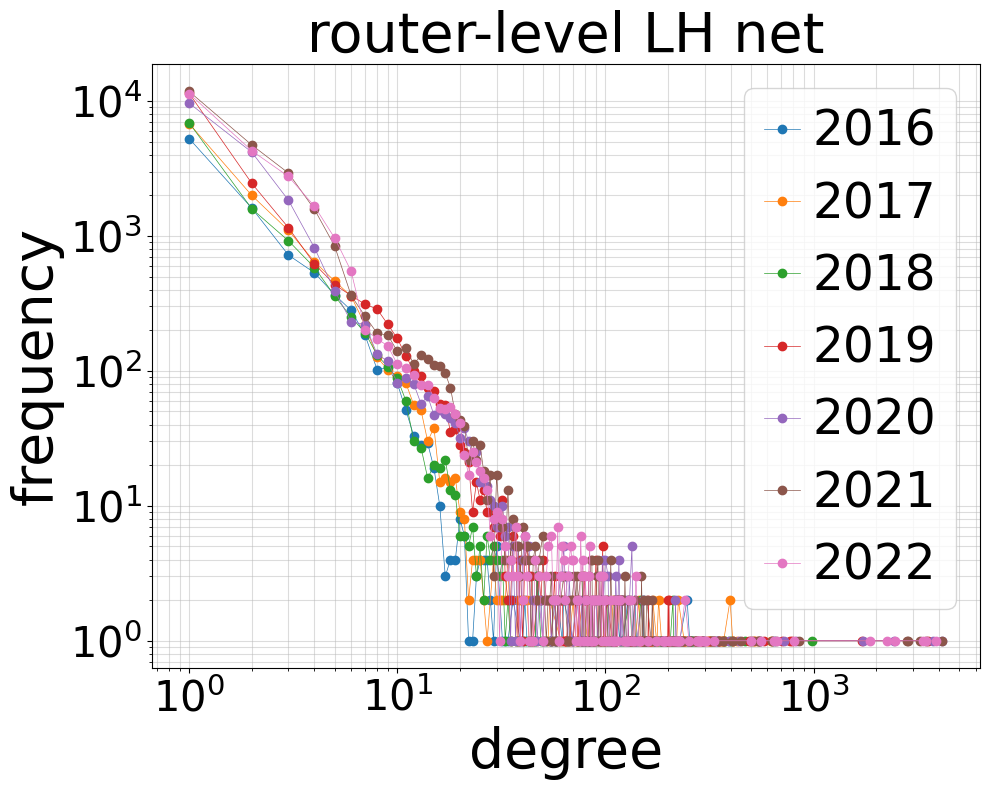

In [9]:
fig, ax = plt.subplots(1, figsize=(10, 8))
ax.yaxis.grid(True, linestyle='-', color='#bababa', alpha=0.5, which='both')
ax.xaxis.grid(True, linestyle='-', color='#bababa', alpha=0.5, which='both')

for cycle in [4577, 5423, 6447, 7616, 8821, 9644, 10020]:
    # concat_df = pd.DataFrame()
    # for _cycle in range(cycle -1, cycle + 2):
    #     # concat_df = concat_df.append(filtered_geoloc_hops[_cycle])
    #     concat_df = pd.concat([concat_df, filtered_geoloc_hops[_cycle]])
    
    df = pd.read_csv(f"data/processed/snapshots-longitudinal/{cycle}.csv.gz", compression="gzip")
    G = generate_graph(df)
    
    x = pd.DataFrame(Counter(list(dict(G.degree()).values())).items(), columns=["deg", "cnt"])
    x = x.sort_values("deg")

#     ax.scatter(
#         x["deg"],
#         x["cnt"],
#         label=cycle,
#         s=10
#     )
    ax.plot(
        x["deg"],
        x["cnt"],
        label=cycle2year[cycle],
        lw=0.5,
        marker="o"
    )
    
ax.set_xscale('log')
ax.set_yscale('log')

ax.tick_params(labelsize=30)
ax.set_xlabel("degree", fontsize=40)
ax.set_ylabel("frequency", fontsize=40)

ax.legend(loc='upper right', ncol=1, frameon=True, fontsize=35,
          handletextpad=0.25, columnspacing=0.5, handlelength=0.75)

ax.set_title("router-level LH net", fontsize=40)
fig.subplots_adjust(hspace=0)
fig.tight_layout()
# fig.savefig("figures/lhnet/router_dist.pdf")

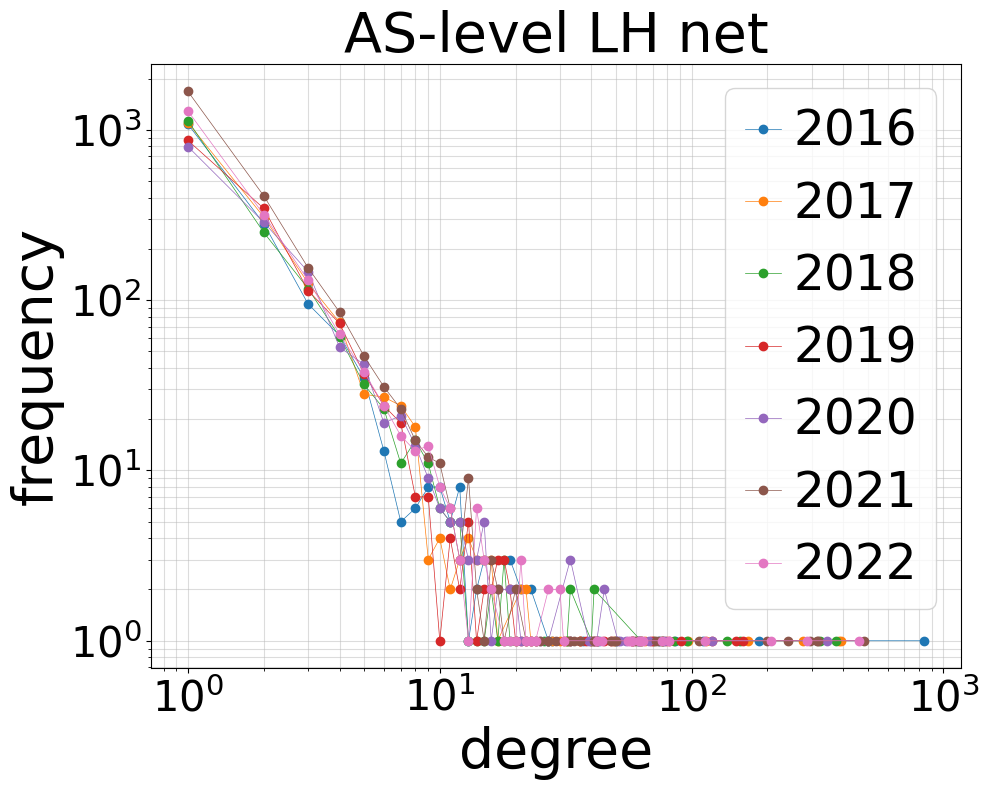

In [10]:
fig, ax = plt.subplots(1, figsize=(10, 8))
ax.yaxis.grid(True, linestyle='-', color='#bababa', alpha=0.5, which='both')
ax.xaxis.grid(True, linestyle='-', color='#bababa', alpha=0.5, which='both')


for cycle in [4577, 5423, 6447, 7616, 8821, 9644, 10020]:
    
    df = pd.read_csv(f"data/processed/snapshots-longitudinal/{cycle}.csv.gz", compression="gzip")
    G = generate_graph(df)
    
    
    Gasn = nx.Graph()
    
    for n1 in G.nodes():
        for n2 in G.neighbors(n1):
            Gasn.add_edge(G.nodes[n1]["asn"], G.nodes[n2]["asn"])
    
    x = pd.DataFrame(Counter(list(dict(Gasn.degree()).values())).items(), columns=["deg", "cnt"])
    x = x.sort_values("deg")

    ax.plot(
        x["deg"],
        x["cnt"],
        label=cycle2year[cycle],
        lw=0.5,
        marker="o"
    )
    
    
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("degree", fontsize=40)
ax.set_ylabel("frequency", fontsize=40)

ax.tick_params(labelsize=30)

ax.legend(loc='upper right', ncol=1, frameon=True, fontsize=35,
          handletextpad=0.25, columnspacing=0.5, handlelength=0.75)

ax.set_title("AS-level LH net", fontsize=40)

fig.subplots_adjust(hspace=0)
fig.tight_layout()
# fig.savefig("figures/lhnet/as_dist.pdf")

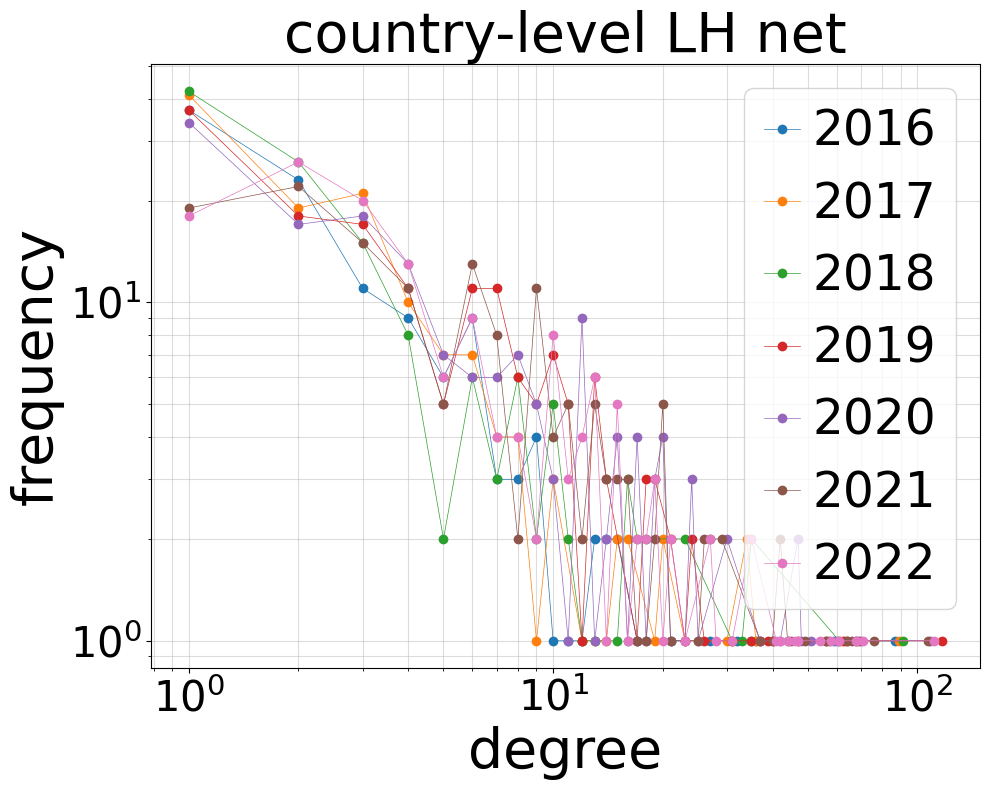

In [11]:
fig, ax = plt.subplots(1, figsize=(10, 8))
ax.yaxis.grid(True, linestyle='-', color='#bababa', alpha=0.5, which='both')
ax.xaxis.grid(True, linestyle='-', color='#bababa', alpha=0.5, which='both')


for cycle in [4577, 5423, 6447, 7616, 8821, 9644, 10020]:

    df = pd.read_csv(f"data/processed/snapshots-longitudinal/{cycle}.csv.gz", compression="gzip")
    G = generate_graph(df)
    
    
    Gcc = nx.Graph()
    
    for n1 in G.nodes():
        for n2 in G.neighbors(n1):
            Gcc.add_edge(G.nodes[n1]["cc"], G.nodes[n2]["cc"])
    
    x = pd.DataFrame(Counter(list(dict(Gcc.degree()).values())).items(), columns=["deg", "cnt"])
    x = x.sort_values("deg")

    ax.plot(
        x["deg"],
        x["cnt"],
        label=cycle2year[cycle],
        lw=0.5,
        marker="o"
    )
    
ax.set_xscale('log')
ax.set_yscale('log')
ax.tick_params(labelsize=30)
ax.set_xlabel("degree", fontsize=40)
ax.set_ylabel("frequency", fontsize=40)

ax.legend(loc='upper right', ncol=1, frameon=True, fontsize=35,
          handletextpad=0.25, columnspacing=0.5, handlelength=0.75)

ax.set_title("country-level LH net", fontsize=40)

fig.subplots_adjust(hspace=0)
fig.tight_layout()
# fig.savefig("figures/lhnet/cc_dist.pdf")

# fitting data to Powerlaw

In [12]:
l = []
for cycle in [4577, 5423, 6447, 7616, 8821, 9644, 10020]:

    df = pd.read_csv(f"data/processed/snapshots-longitudinal/{cycle}.csv.gz", compression="gzip")
    G = generate_graph(df)
    G.remove_edges_from(nx.selfloop_edges(G))
    
    x = pd.DataFrame(Counter(list(dict(G.degree()).values())).items(), columns=["deg", "cnt"])
    x = x.sort_values("deg")
    
    d = np.array(list(dict(G.degree()).values()))
    results = powerlaw.Fit(d[~np.isnan(d)])
    R, p = results.distribution_compare('power_law', 'lognormal')
    l.append((cycle, results.power_law.alpha, results.power_law.xmin, R > 0, p > 0.05))



Calculating best minimal value for power law fit


/home/esteban/projects/lhl-edge/.lhl-edge/lib/python3.10/site-packages/powerlaw.py:1615: RuntimeWarning: invalid value encountered in divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


/home/esteban/projects/lhl-edge/.lhl-edge/lib/python3.10/site-packages/powerlaw.py:1615: RuntimeWarning: invalid value encountered in divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
/home/esteban/projects/lhl-edge/.lhl-edge/lib/python3.10/site-packages/powerlaw.py:1615: RuntimeWarning: invalid value encountered in divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


Calculating best minimal value for power law fit


/home/esteban/projects/lhl-edge/.lhl-edge/lib/python3.10/site-packages/powerlaw.py:1615: RuntimeWarning: invalid value encountered in divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


Calculating best minimal value for power law fit


/home/esteban/projects/lhl-edge/.lhl-edge/lib/python3.10/site-packages/powerlaw.py:1615: RuntimeWarning: invalid value encountered in divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


Calculating best minimal value for power law fit


/home/esteban/projects/lhl-edge/.lhl-edge/lib/python3.10/site-packages/powerlaw.py:1615: RuntimeWarning: invalid value encountered in divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


Calculating best minimal value for power law fit


/home/esteban/projects/lhl-edge/.lhl-edge/lib/python3.10/site-packages/powerlaw.py:1615: RuntimeWarning: invalid value encountered in divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


In [13]:
pd.DataFrame(l, columns=["year", "alpha", "xmin", "powerlaw", "confident"])

,year,alpha,xmin,powerlaw,confident
0,4577,2.795266,5.0,True,False
1,5423,2.776919,5.0,True,False
2,6447,2.681417,5.0,False,True
3,7616,2.544647,7.0,True,True
4,8821,2.308425,11.0,False,True
5,9644,2.314607,76.0,True,True
6,10020,2.278652,9.0,False,True


In [14]:
l = []
for cycle in [4577, 5423, 6447, 7616, 8821, 9644, 10020]:

    df = pd.read_csv(f"data/processed/snapshots-longitudinal/{cycle}.csv.gz", compression="gzip")
    G = generate_graph(df)
    
    Gasn = nx.Graph()
    
    for n1 in G.nodes():
        for n2 in G.neighbors(n1):
            if G.nodes[n1]["asn"] != G.nodes[n2]["asn"]:
                Gasn.add_edge(G.nodes[n1]["asn"], G.nodes[n2]["asn"])

    
    results = powerlaw.Fit(list(dict(Gasn.degree()).values()))
    R, p = results.distribution_compare('lognormal', 'power_law', )
    l.append((cycle, results.power_law.alpha, results.power_law.xmin, R > 0, p > 0.05))

    


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


/home/esteban/projects/lhl-edge/.lhl-edge/lib/python3.10/site-packages/powerlaw.py:1615: RuntimeWarning: invalid value encountered in divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
/home/esteban/projects/lhl-edge/.lhl-edge/lib/python3.10/site-packages/powerlaw.py:1615: RuntimeWarning: invalid value encountered in divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


Calculating best minimal value for power law fit


/home/esteban/projects/lhl-edge/.lhl-edge/lib/python3.10/site-packages/powerlaw.py:1615: RuntimeWarning: invalid value encountered in divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


Calculating best minimal value for power law fit


/home/esteban/projects/lhl-edge/.lhl-edge/lib/python3.10/site-packages/powerlaw.py:1615: RuntimeWarning: invalid value encountered in divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


Calculating best minimal value for power law fit


/home/esteban/projects/lhl-edge/.lhl-edge/lib/python3.10/site-packages/powerlaw.py:1615: RuntimeWarning: invalid value encountered in divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


Calculating best minimal value for power law fit


/home/esteban/projects/lhl-edge/.lhl-edge/lib/python3.10/site-packages/powerlaw.py:1615: RuntimeWarning: invalid value encountered in divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


Calculating best minimal value for power law fit


/home/esteban/projects/lhl-edge/.lhl-edge/lib/python3.10/site-packages/powerlaw.py:1615: RuntimeWarning: invalid value encountered in divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


In [15]:
pd.DataFrame(l, columns=["year", "alpha", "xmin", "powerlaw", "confident"])

,year,alpha,xmin,powerlaw,confident
0,4577,2.220696,7.0,True,True
1,5423,2.467399,3.0,True,True
2,6447,2.447342,3.0,True,True
3,7616,2.556475,2.0,True,True
4,8821,2.304755,4.0,True,True
5,9644,2.475399,3.0,True,True
6,10020,2.232232,4.0,True,True


In [16]:
l = []
for cycle in [4577, 5423, 6447, 7616, 8821, 9644, 10020]:

    df = pd.read_csv(f"data/processed/snapshots-longitudinal/{cycle}.csv.gz", compression="gzip")
    G = generate_graph(df)
    
    Gcc = nx.Graph()
    
    for n1 in G.nodes():
        for n2 in G.neighbors(n1):
            if G.nodes[n1]["cc"] != G.nodes[n2]["cc"]:
                Gcc.add_edge(G.nodes[n1]["cc"], G.nodes[n2]["cc"])


    results = powerlaw.Fit(list(dict(Gcc.degree()).values()))
    R, p = results.distribution_compare('lognormal', 'power_law', )
    l.append((cycle, results.power_law.alpha, results.power_law.xmin, R > 0, p > 0.05))
    


Calculating best minimal value for power law fit


/home/esteban/projects/lhl-edge/.lhl-edge/lib/python3.10/site-packages/powerlaw.py:1615: RuntimeWarning: invalid value encountered in divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


Calculating best minimal value for power law fit


/home/esteban/projects/lhl-edge/.lhl-edge/lib/python3.10/site-packages/powerlaw.py:1615: RuntimeWarning: invalid value encountered in divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


In [17]:
pd.DataFrame(l, columns=["year", "alpha", "xmin", "powerlaw", "confident"])

,year,alpha,xmin,powerlaw,confident
0,4577,2.511426,6.0,True,True
1,5423,2.275289,3.0,True,False
2,6447,2.416122,7.0,True,True
3,7616,2.395343,7.0,True,True
4,8821,2.685028,12.0,True,True
5,9644,2.369631,9.0,True,True
6,10020,2.466491,10.0,True,True
